##### Copyright 2019 Google LLC.

Licensed under the Apache License, Version 2.0 (the "License");

In [ ]:
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Fashion MNIST Classifier Using Keras

The code below was presented during the practical part of the Google Tech Learning Series class about Machine Learning.

Please make a copy in Drive (see the "File" menu) and run the cells one by one to download the dataset, train the model and inspect some predictions.

## Initialize

In [ ]:
# Some useful libraries.
import itertools
from matplotlib import pyplot as plt

In [ ]:
# Note : In the recording we have used TensorFlow 1.15 - in the meantime
# Tensorflow 2 has been released and we'll use the new version. Because we have
# been using Keras, no updates to our code is needed.
%tensorflow_version 2.x

TensorFlow 2.x selected.


In [ ]:
import tensorflow as tf
print(f'TF version={tf.__version__}')
# Do you want to train with a GPU? Simply "Change runtime type" in the "Runtime"
# menu and re-execte the cells.
print(f'GPUS={tf.config.list_physical_devices("GPU")}')

TF version=2.1.0
GPUS=[]


## Download and Inspect the Data

In [ ]:
# Download MNIST dataset from the web.
# See more datasets on https://www.tensorflow.org/datasets/datasets
import tensorflow_datasets as tfds
ds, info = tfds.load('fashion_mnist', with_info=True)

In [ ]:
info

tfds.core.DatasetInfo(
    name='fashion_mnist',
    version=3.0.0,
    description='Fashion-MNIST is a dataset of Zalando's article images consisting of a training set of 60,000 examples and a test set of 10,000 examples. Each example is a 28x28 grayscale image, associated with a label from 10 classes.',
    homepage='https://github.com/zalandoresearch/fashion-mnist',
    features=FeaturesDict({
        'image': Image(shape=(28, 28, 1), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=10),
    }),
    total_num_examples=70000,
    splits={
        'test': 10000,
        'train': 60000,
    },
    supervised_keys=('image', 'label'),
    citation="""@article{DBLP:journals/corr/abs-1708-07747,
      author    = {Han Xiao and
                   Kashif Rasul and
                   Roland Vollgraf},
      title     = {Fashion-MNIST: a Novel Image Dataset for Benchmarking Machine Learning
                   Algorithms},
      journal   = {CoRR},
      volume

In [ ]:
# Datasets are iterables. Let's fetch the first example:
for example in ds['train']:
    break
example.keys()

dict_keys(['image', 'label'])

Image shape=(28, 28, 1)


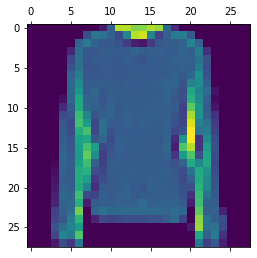

In [ ]:
print(f'Image shape={example["image"].shape}')
# The image has a last dimension of `1` because it contains a single grayscale
# channel. Make the shape (28, 28) for drawing with Matplotlib.
plt.matshow(example['image'][:,:,0])

In [ ]:
# The label is specified as a number.
example['label']

<tf.Tensor: shape=(), dtype=int64, numpy=2>

In [ ]:
# The additional data in `info` let's use convert that number to a string label.
info.features['label'].names

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

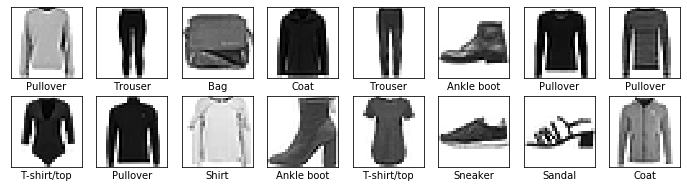

In [ ]:
# Let's plot some more examples...
rows, cols = 2, 8
plt.figure(figsize=(1.5*cols, 1.5*rows))
for i, example in enumerate(itertools.islice(ds['train'], rows*cols)):
    plt.subplot(rows, cols, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(example['image'].numpy().reshape((28, 28)), cmap=plt.cm.binary)
    label_index = example['label'].numpy()
    plt.xlabel(info.features['label'].names[label_index])

## Define the Model

In [ ]:
# Define the model; see presentation for additional explanations.
model = tf.keras.Sequential([
    # We need to specify the input shape of the first layer only.
    tf.keras.layers.Flatten(input_shape=(28, 28, 1)),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')
])

In [ ]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 128)               100480    
_________________________________________________________________
dense_1 (Dense)              (None, 10)                1290      
Total params: 101,770
Trainable params: 101,770
Non-trainable params: 0
_________________________________________________________________


## Train the Model

In [ ]:
# Keras .fit() function expects dataset containing (data, label).
# This function maps the dictionary from tfds to this expected tuple.
def map_features(example):
    return (
        example['image'],
        example['label'],
    )
# Train the model with batches of size 128.
train_ds = ds['train'].map(map_features).batch(128)
model.fit(train_ds, epochs=1)

469/469 [==============================] - 15s 32ms/step - loss: 6.6240 - accuracy: 0.7251


## Inspect some Predictions

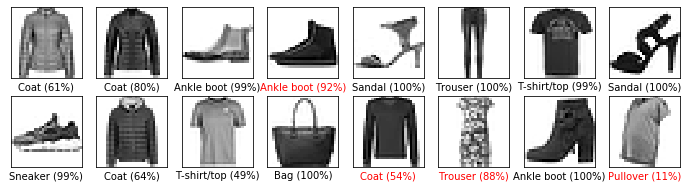

In [ ]:
# Show predictions with their "confidence" (note that this confidence is simply
# the value of the largest activation in the output layer and this is by no
# means calibrated, sometimes you will even see predictions with ~100%
# "confidence" that are still wrong...)
# Incorrect predictions are shown with red text.
rows, cols = 2, 8
plt.figure(figsize=(1.5*cols, 1.5*rows))
examples = []
for i, example in enumerate(itertools.islice(ds['test'], rows*cols)):
    examples.append(example)
    plt.subplot(rows, cols, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(example['image'].numpy().reshape((28, 28)), cmap=plt.cm.binary)
    # tf.expand_dims() changes the shape (28, 28, 1) -> (1, 28, 28, 1)
    # This is needed because the model expects a batch of images (batch
    # dimension is the first dimension).
    prediction = model.predict(tf.expand_dims(example['image'], 0))[0]
    predicted_index = prediction.argmax()
    predicted_name = info.features['label'].names[predicted_index]
    label_index = example['label']
    predicted_pct = int(100 * prediction.max())
    fmt_kwargs = {}
    if example['label'].numpy() != predicted_index:
        fmt_kwargs['color'] = 'red'
    plt.xlabel(f'{predicted_name} ({predicted_pct}%)', **fmt_kwargs)

Prediction=Coat Label=Coat


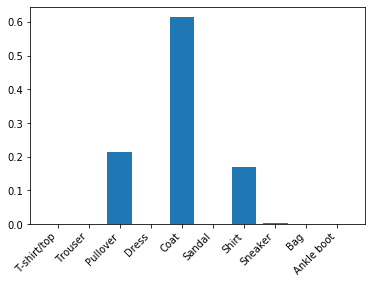

In [ ]:
# Inspect an individual example from above.
example = examples[0]
pred = model.predict(tf.expand_dims(example['image'], 0))[0]
plt.bar(range(len(pred)), pred)
plt.xticks(range(len(pred)), info.features['label'].names)
plt.setp(plt.gca().get_xticklabels(), rotation=45, horizontalalignment='right')
print('Prediction={} Label={}'.format(
    info.features['label'].names[pred.argmax()],
    info.features['label'].names[example['label']],
))

## Go Further

This is a very simple working example and there are many ways to improve it, some ideas:

- Train for more episodes. You can also repeatedly execute the cell with `model.fit()` - as long as you don't re-initialize the model, the trainings will be accumulative.
- Change batch size.
- Change number of layers and number of units per layer.
- Measure the accuracy of the model on the test set: read about [model.evaluate()](https://keras.io/api/models/model_training_apis/#evaluate-method) and [metrics](https://keras.io/api/metrics/). What happens to train/test metrics when you train for many more epochs?
- Try to use [Regularization](https://keras.io/regularizers/) / [Dropout](https://keras.io/api/layers/regularization_layers/dropout/) and see how the output changes.
- Try more complex model architectures, like convolutional neural networks - for more information on this topic, see for example this [article](https://colah.github.io/posts/2014-07-Conv-Nets-Modular/) or this [video](https://www.youtube.com/watch?v=bNb2fEVKeEo).
- You will notice that the training takes a lot more time when you're using a more complicated model. Try training on GPU (menu: "Runtime / Change runtime type").
- Use the same model with different datasets.

Spending time on questions like these will develop your intuitive understanding of the different parameters, which is an important part of ML practice...